# **8.5 Sentiment Analysis**

### **IMDB Review - Supervised Learning**

일반적인 텍스트 기반의 분류와 거의 동일함, 사실상 텍스트 기반의 이진 분류이다.

In [1]:
import pandas as pd

review_df = pd.read_csv('./labeledTrainData.tsv', header=0, sep="\t", quoting=3)
# sep="\t" 라고 하면 tab으로 분리된 것을 기준으로 분리한다.
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [2]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

'br' 같은 문자, 숫자는 제거한다

In [3]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />',' ')

# 파이썬의 정규 표현식 모듈인 re를 이용하여 영어 문자열이 아닌 문자는 모두 공백으로 변환 
review_df['review'] = review_df['review'].apply( lambda x : re.sub("[^a-zA-Z]", " ", x) )
# 첫째 문자가 영어문자가 아닌 것들을 공백으로 변화하라는 의미

# 정규표현식은 텍스트 분석을 하는 사람은 반드시 다루어야한다.

##### **Train, Test split**

In [4]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id','sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test= train_test_split(feature_df, class_df, test_size=0.3, random_state=156)

X_train.shape, X_test.shape
# 리뷰만 뽑아냈다.

((17500, 1), (7500, 1))

**Apply CountVectorizer**

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, filtering, ngram은 (1,2)로 설정해 CountVectorization수행. 
# LogisticRegression의 C는 10으로 설정. 
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10))])

# Pipeline 객체를 이용하여 fit(), predict()로 학습/예측 수행. predict_proba()는 roc_auc때문에 수행.  
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

C:\Users\cailab\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도는 0.8860, ROC-AUC는 0.9503


**Apply TF-IDF**

In [6]:
# 스톱 워드는 english, filtering, ngram은 (1,2)로 설정해 TF-IDF 벡터화 수행. 
# LogisticRegression의 C는 10으로 설정. 
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10))])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


### **IMDB Review - UnSupervised Learning**

감성 어휘 사전을 이용한다. 사전은 용어와 문맥에 대한 다양한 정보를 가지고 있으며 이를 통해 문서의 긍정적, 부정적 감성 여부를 판단한다.

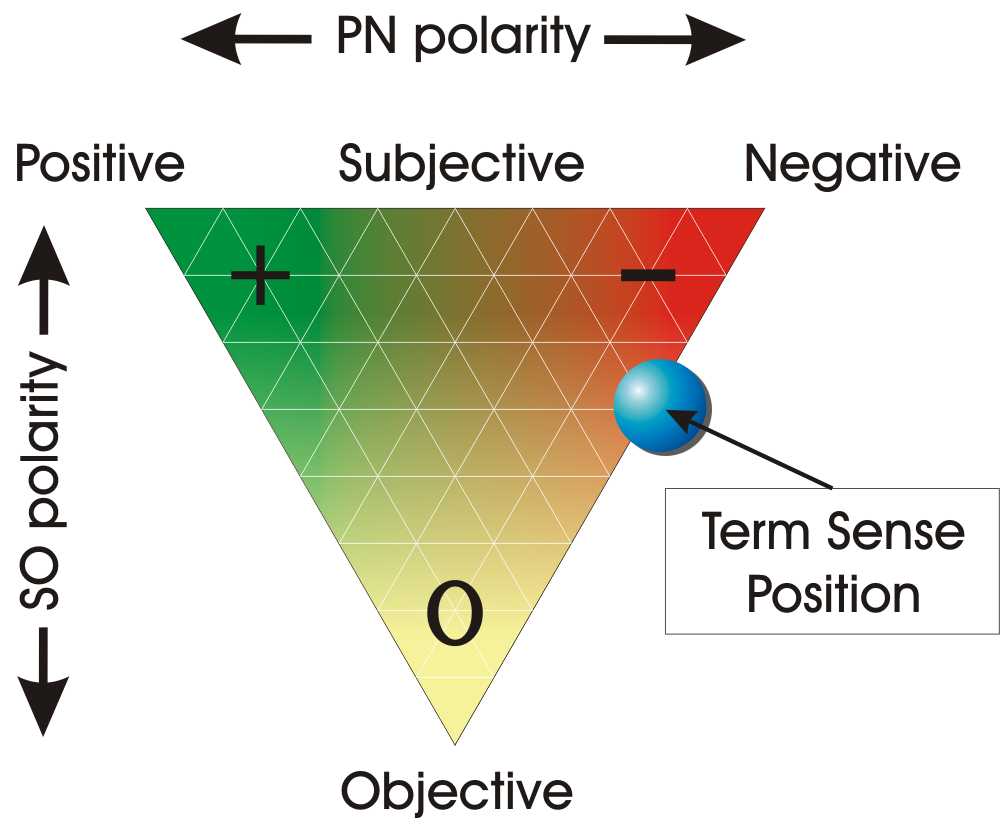

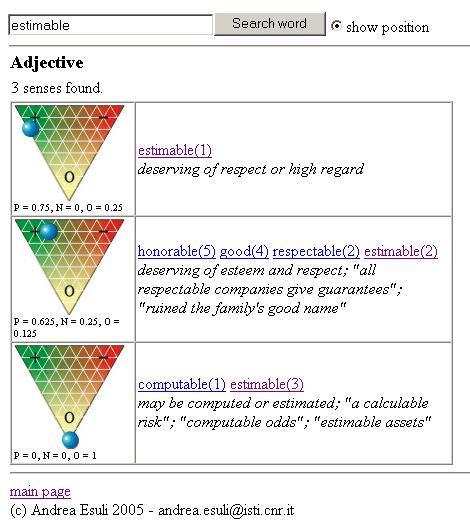

**VADER Lexicon >> Sentiment Analysis**

In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cailab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [9]:
def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환 
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply( lambda x : vader_polarity(x, 0.1) )
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

In [10]:
print('#### VADER 예측 성능 평가 ####')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score

print(confusion_matrix( y_target, vader_preds))
print("정확도:", accuracy_score(y_target , vader_preds))
print("정밀도:", precision_score(y_target , vader_preds))
print("재현율:", recall_score(y_target, vader_preds))

#### VADER 예측 성능 평가 ####
[[ 6747  5753]
 [ 1858 10642]]
정확도: 0.69556
정밀도: 0.6491003354681305
재현율: 0.85136


polarity_scores를 이용해 감성점수를 구한 뒤에 임계점 이상이면 해당 문서는 긍정이다.

감성사전을 이용한 예측은 지도학습 기반보다 성능이 떨어진다. 결정 클래스값이 없으면 고려가능하다.